# Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [75]:
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt


# Get Matplotlib patches for various elliptical confidence regions
def get_ellipse_patch(center, cov, confidence=0.95):
    # Figure out number of stdevs for confidence
    scale = math.sqrt(scipy.stats.chi2.ppf(q=confidence, df=center.shape[0]))
    
    u, s, vh = np.linalg.svd(cov)
    # If det < 0, reflect either u_1 or u_2 to its negative, may as well do u_2
    # For arccos, need y-value of u_1 to be positive
    if u[0,1] < 0:
        u[:,0] = -u[:,0]
    th = np.arccos(np.dot(np.array([1, 0]), u[:,0])) * 180 / np.pi
    print(np.sqrt(np.linalg.det(cov)))
    return Ellipse((center[0], center[1]), np.sqrt(s[0]) * scale * 2, np.sqrt(s[1])* scale * 2, angle=th, alpha=0.5, color='red')



# Check if the confidence region contains a list of points
# center shape (n,), covariance shape (n,n), points shape (p, n) where p is number of points
# Returns shape (n, 1) boolean
def ellipse_contains_points(center, covariance, points, confidence=0.95):
    u, s, vh = np.linalg.svd(covariance)
    a = u @ np.diag(np.sqrt(s))
    return np.linalg.norm((points - center) @ np.linalg.inv(a).T, axis=1) ** 2 < scipy.stats.chi2.ppf(q=confidence, df=center.shape[0])
    

# Gets patches and containment data for a given fitted GaussianMixture object
# Returns an list of patches, a Numpy array of containment data
def get_patches(gm, confidence, pts):
    patches = []
    contains = []
    for i in range(gm.means_.shape[0]):
        e = get_ellipse_patch(gm.means_[i], gm.covariances_[i], confidence=confidence)
        patches.append(e)
        contains.append(ellipse_contains_points(gm.means_[i], gm.covariances_[i], pts, confidence))

    return patches, np.stack(contains, axis=0)


# Algorithm for determining the number of components according to our winnowing criteria: no overlaps, and each 95% confidence region should contain 10% of all data points
def winnow_gm_components(data, start=10, confidence_limit=0.95):
    for i in range(start, 0, -1):
        gm = GaussianMixture(n_components=i)
        gm.fit(data)
        # If i = 1, then we are done anyway, so break
        if i == 1:
            break

        contains = []
        for j in range(i):
            contains.append(ellipse_contains_points(gm.means_[j], gm.covariances_[j], data, confidence=confidence_limit))
        contains = np.stack(contains)

        # Check if there are any overlaps, if so, continue
        if (contains.sum(axis=0) <= 1).prod().item() != 1:
            continue
        # Check if any ellipses contain less than 10% of data points
        if (contains.sum(axis=1) >= data.shape[0]/10).prod().item() != 1:
            continue
        # Otherwise, we are done
        return gm, i
        
    return gm, i


## Test on some generated data sets

Generate a single 2d normal distribution

(1000, 2)


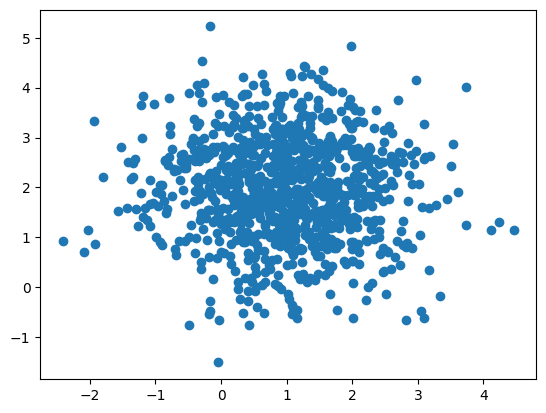

In [76]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[0.9754977  1.96147208]] [[[ 0.99971608 -0.04145756]
  [-0.04145756  1.03501009]]]
1.016364846503078
Num covered: 0.899, valid covered: 0.899, overlapped: 0.0


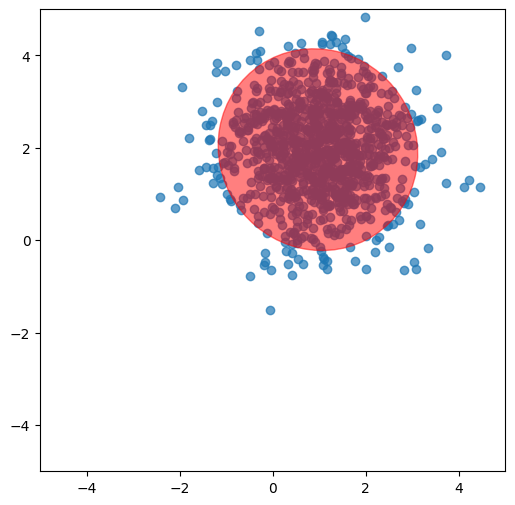

In [77]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [78]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


101
1000
patch way: 0
my way: 950


1.016364846503078


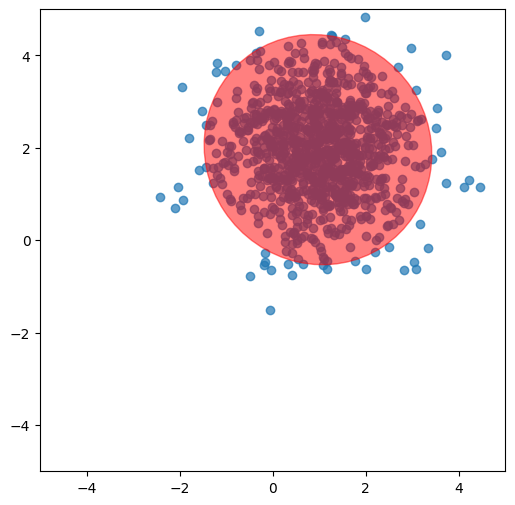

In [79]:
gm, i = winnow_gm_components(data)
i
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(500, 2)


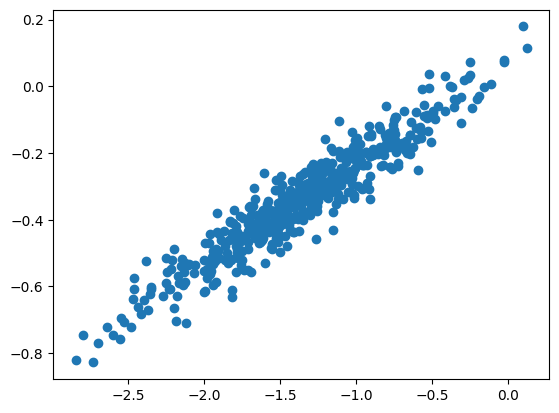

In [80]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = x2
y = y2


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)

[[-1.35656803 -0.33818933]] [[[0.27568008 0.08221236]
  [0.08221236 0.02724514]]]
0.027423884888193764
0.938


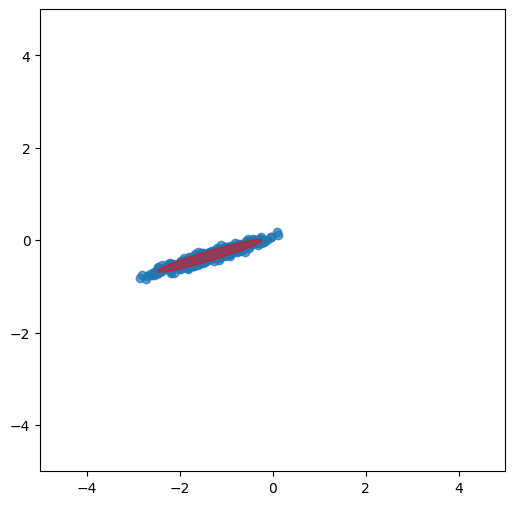

In [81]:
gm = GaussianMixture(n_components=1)
gm.fit(data)
print(gm.means_, gm.covariances_)

patches, coverage = get_patches(gm, 0.9, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]

print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")


(1500, 2)


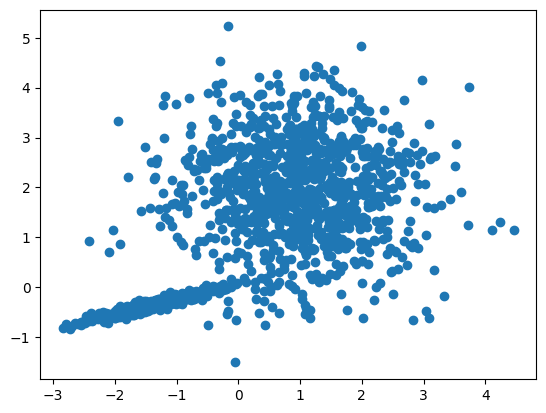

In [82]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[ 0.97287903  1.95889957]
 [-1.35673103 -0.33836967]] [[[ 1.00322399 -0.03588491]
  [-0.03588491  1.03946755]]

 [[ 0.27881993  0.08296751]
  [ 0.08296751  0.02740261]]]
1.0205542898966418
0.027509713623323814


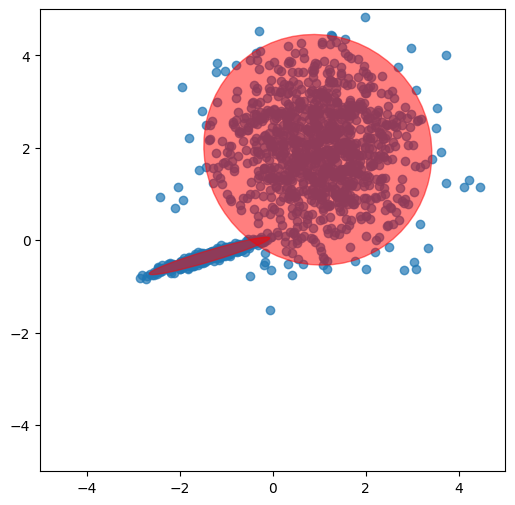

In [83]:
gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

1.5056104932046706


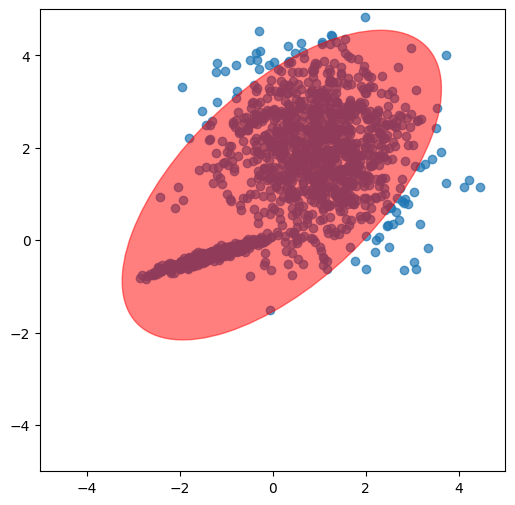

In [84]:
gm, i = winnow_gm_components(data)
i


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


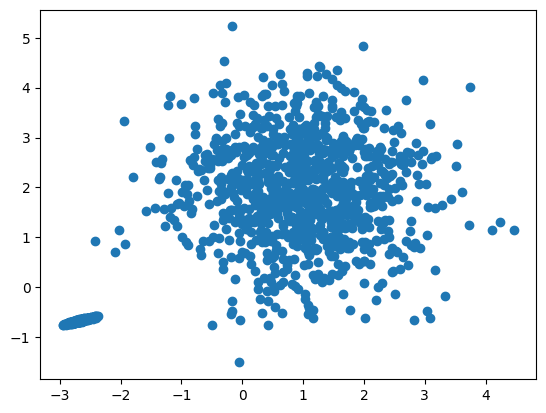

In [85]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



1.01636763011928
0.00110309624040397


2

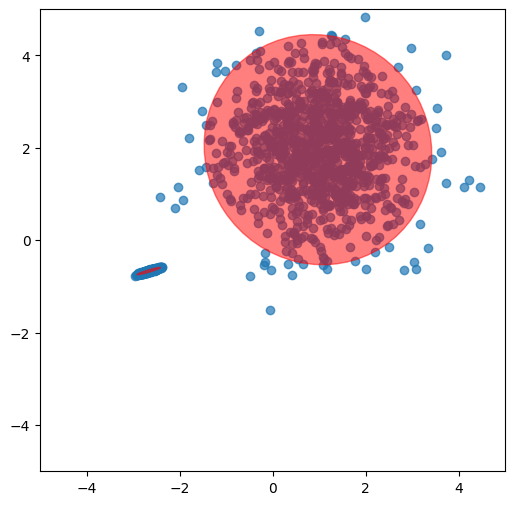

In [86]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


gm, i = winnow_gm_components(data)
i

### Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


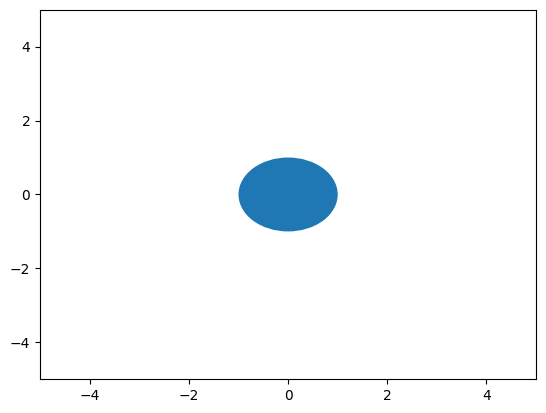

In [87]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

## Apply to beat data

### Get measure data

In [88]:
def beat_frames_to_toy(frames, len, target_len):
    x = np.zeros(len + ((target_len - len) % target_len))
    x[frames] = 1
    x = x.reshape((target_len, -1))
    x = x.max(axis=1)
    return x

def beat_frames_to_better_toy(frames, len, target_lens):
    outs = []
    for t in target_lens:
        outs.append(beat_frames_to_toy(frames, len, t) /t )
    return np.concatenate(outs)


In [89]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
#from groove.embedding import beat_frames_to_toy
import numpy as np

file = "milaklaw"

raw, proc, sr = get_measures(file, smooth_power)
bf, nf = get_beat_frames(proc, sr, beat_peaks)

In [90]:
frames = np.array([4,4,7,9,11])

print(beat_frames_to_toy(frames, 12, 6))
print(beat_frames_to_better_toy(frames, 12, [6, 4, 3, 2]))

[0. 0. 1. 1. 1. 1.]
[0.         0.         0.16666667 0.16666667 0.16666667 0.16666667
 0.         0.25       0.25       0.25       0.         0.33333333
 0.33333333 0.5        0.5       ]


In [91]:
out = []
hashable = []
for i in range(len(bf)):
    a = beat_frames_to_better_toy(bf[i], nf[i], [24, 12, 8, 6, 4, 2])
    out.append(a)
    hashable.append(tuple(a.tolist()))

data = np.stack(out)
data.shape


(179, 56)

In [92]:
import collections
counter = collections.Counter(hashable)

print(counter.values())
md = counter.most_common(3)
print(hashable.index(md[0][0]), hashable.index(md[1][0]), hashable.index(md[2][0]))



dict_values([17, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 14, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 9, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
0 23 125


In [93]:
beat_frames_to_toy(bf[20], nf[20], 12)

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

[1.37094877 1.31549518]
0.002842372879615569
0.00427350153541626


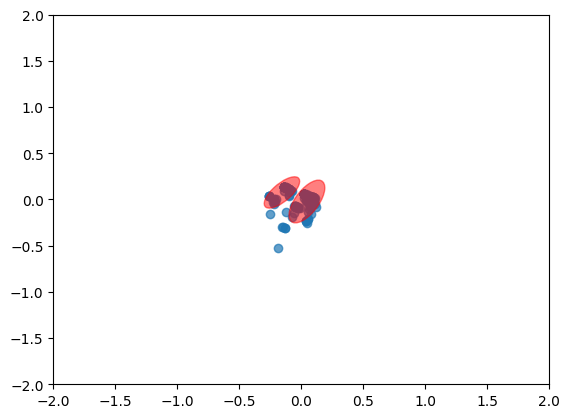

In [94]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gm = GaussianMixture(n_components=2)


pca.fit(data)

print(pca.singular_values_)
red_data = pca.transform(data)

gm.fit(red_data)

patches, coverage = get_patches(gm, 0.95, red_data)

plt.figure()
ax = plt.gca()
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])



plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


#gm.fit(data)
#gm.means_.round()

Some rules for choosing the number of components:
1) If there are overlaps between the 95%ile circles, we should reduce.
2) If any circles don't cover 10%, we reduce.

So, start with more, then reduce.

In [95]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm, i = winnow_gm_components(data)

print(i)
gm.means_

4


array([[0.03603604, 0.00112613, 0.        , 0.02927928, 0.01463964,
        0.01351351, 0.03153153, 0.00225225, 0.00112613, 0.02702703,
        0.01238739, 0.00788288, 0.03490991, 0.00563063, 0.00112613,
        0.02927928, 0.01801802, 0.01126126, 0.03265766, 0.0045045 ,
        0.00337838, 0.03941441, 0.00563063, 0.        , 0.07207207,
        0.05855856, 0.0518018 , 0.06531532, 0.05630631, 0.03828829,
        0.07432432, 0.06081081, 0.0472973 , 0.06981982, 0.08333333,
        0.01126126, 0.10810811, 0.125     , 0.10135135, 0.125     ,
        0.11148649, 0.11148649, 0.10810811, 0.125     , 0.16666667,
        0.15765766, 0.16666667, 0.16666667, 0.15765766, 0.16666667,
        0.25      , 0.25      , 0.25      , 0.25      , 0.5       ,
        0.5       ],
       [0.03343621, 0.01028807, 0.00102881, 0.        , 0.        ,
        0.        , 0.03755144, 0.00154321, 0.0005144 , 0.02314815,
        0.02160494, 0.00668724, 0.02674897, 0.00411523, 0.        ,
        0.03292181, 0.01028

(4, 56) (179, 56)
[ 30  32 116  88]


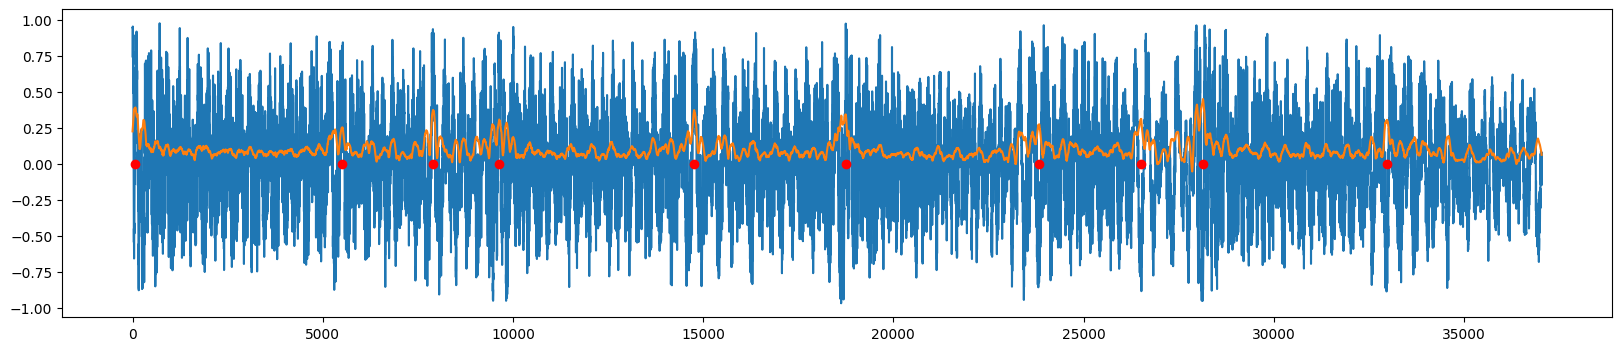

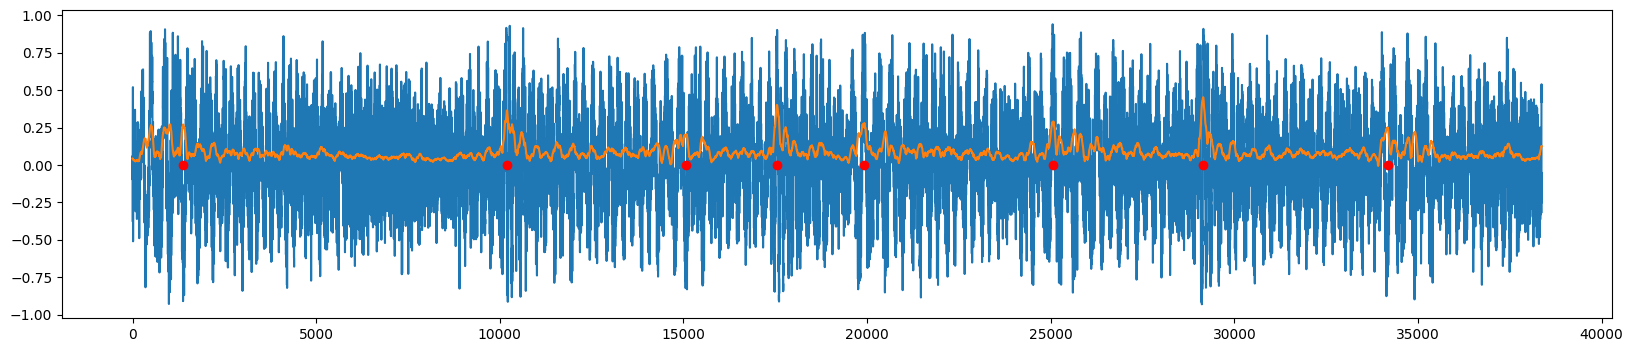

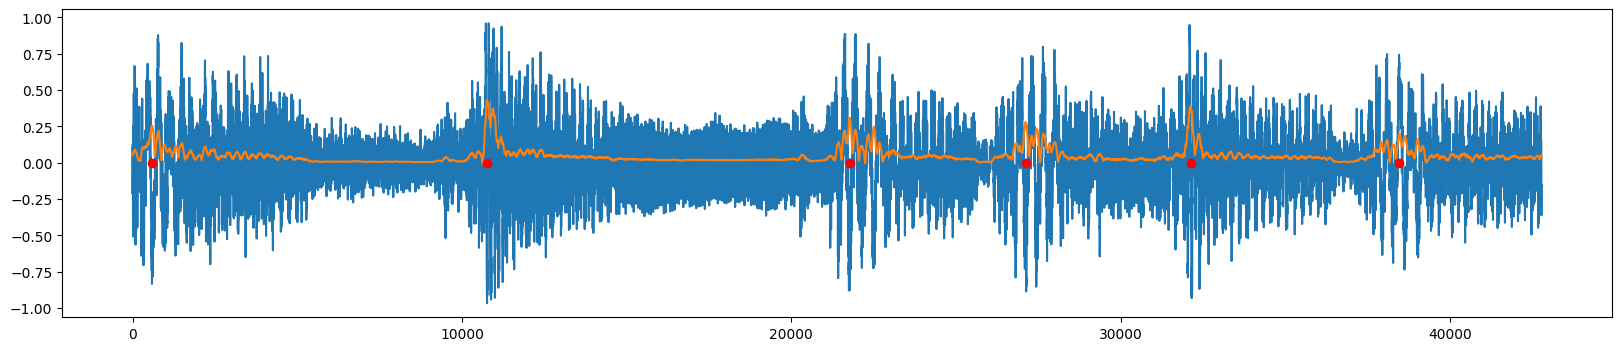

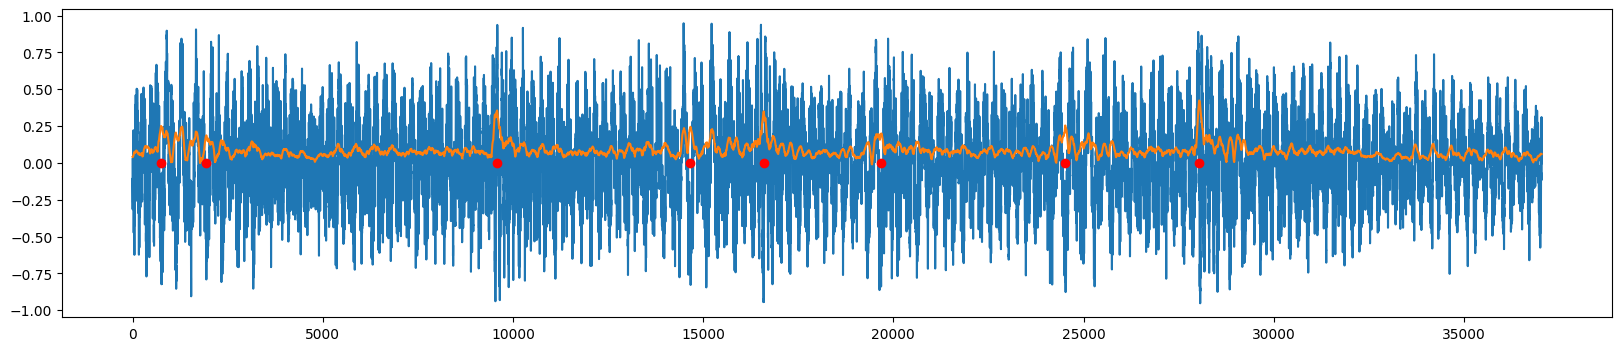

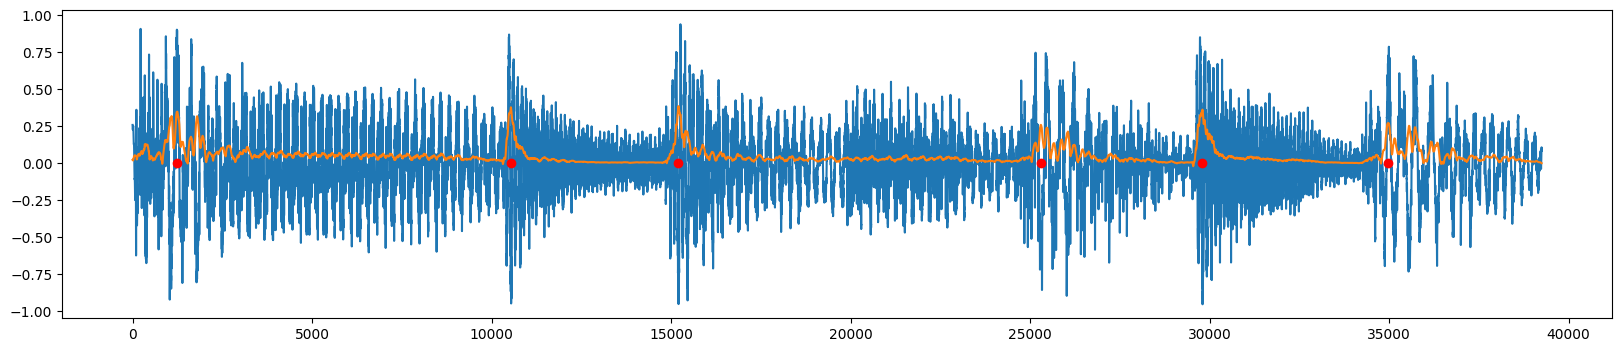

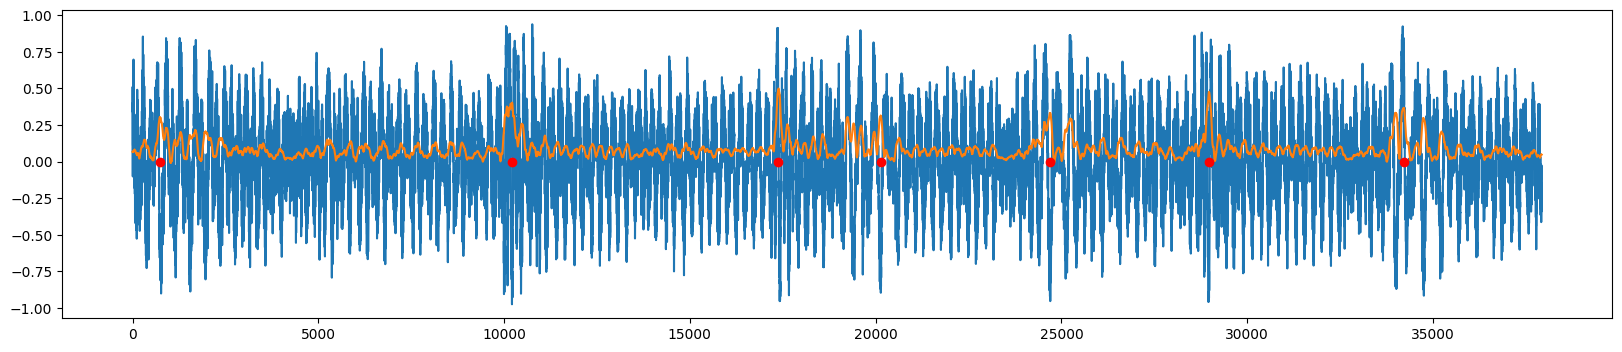

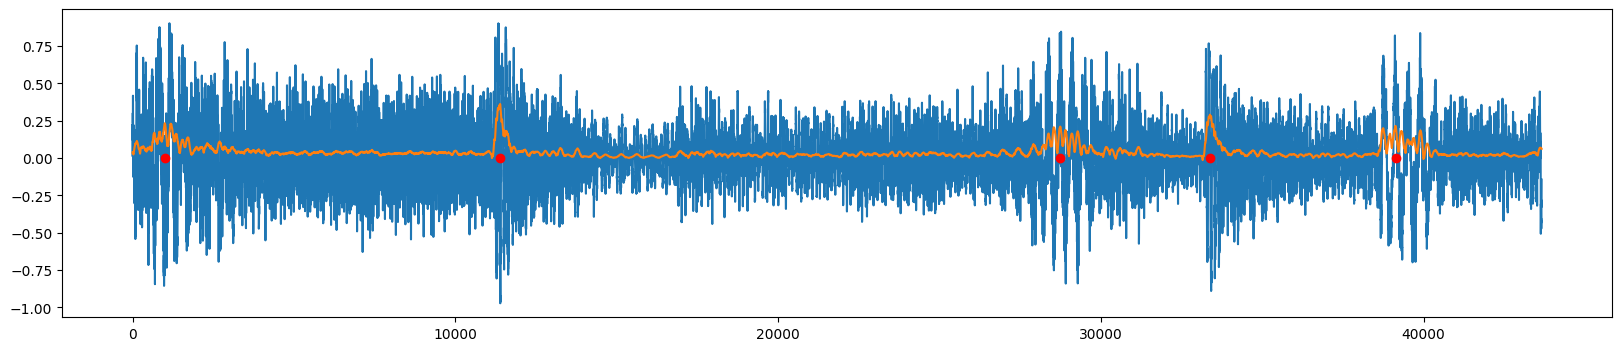

In [96]:
from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa

def find_closest_indices(means, data):
    outs = []
    for i in range(means.shape[0]):
        distances = np.linalg.norm(means[i] - data, axis=1)
        outs.append(distances.argmin(keepdims=True)[0])
    return np.stack(outs)

print(gm.means_.shape, data.shape)

inds = find_closest_indices(gm.means_, data)
data[inds]
print(inds)

inds = np.append(inds, np.array([0, 23, 125]))

raw_measures, proc_measures, sr = get_measures(file, smooth_power)
for i in inds:
    raw, proc = raw_measures[i], proc_measures[i]
    beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
    clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


    plt.figure(figsize=(20, 4))
    plt.plot(raw)
    plt.plot(proc)
    plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
    #display(Audio(data=raw, rate=sr))
    display(Audio(data=raw + clicks, rate=sr))


In [97]:
print(gm.means_[0] - gm.means_[2])
print(np.linalg.norm(gm.covariances_[0]))

[ 2.49945067e-03 -5.98769501e-03 -1.01626016e-03  2.01329378e-02
  1.26071193e-02  1.24972534e-02 -7.08635465e-03 -7.96528236e-04
  1.12612613e-03  2.70270270e-02  1.23873874e-02  7.88288288e-03
  1.66172270e-02  3.59811031e-03 -1.92265436e-03 -2.22478576e-03
  1.09041969e-02  1.02450011e-02 -6.97648868e-03  4.39463854e-04
  3.37837838e-03  1.19753900e-02  1.56558998e-03  0.00000000e+00
  2.96638102e-03  3.82333553e-02  4.57042408e-02 -1.39529774e-02
  5.63063063e-02  3.82882883e-02  3.36739178e-02 -6.26235992e-03
  3.10371347e-02 -9.44847286e-03  2.84552846e-02  3.13117996e-03
  4.44957152e-03  9.45121951e-02 -1.75510877e-02  1.25000000e-01
  4.44133158e-02 -1.31839156e-03 -1.07943309e-02  3.96341463e-02
 -2.77555756e-17 -4.94396836e-03  1.66666667e-01  4.06504065e-03
 -8.78927708e-04  5.28455285e-02  0.00000000e+00  1.21951220e-02
  0.00000000e+00  6.09756098e-03  0.00000000e+00  0.00000000e+00]
0.01052565099683946


My dumb toy embedding magnifies small differences.

In [98]:
print((data[inds[0]] - data[inds[2]])[:24])
print((data[inds[0]] - data[inds[2]])[24:24+12])
print((data[inds[0]] - data[inds[2]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[2]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[2]])[24+12+8+4:24+12+8+4+2])

u = data[inds[0]] - data[inds[2]]
print(np.linalg.norm(u))
print(u)

print((data[inds[0]] - data[inds[1]]))
print((data[inds[0]] - data[inds[1]])[:24])
print(np.linalg.norm(data[inds[0]] - data[inds[1]]))


get_beat_frames([proc_measures[79], proc_measures[23]], sr, beat_peaks)

[0.         0.         0.         0.04166667 0.         0.04166667
 0.         0.         0.         0.04166667 0.         0.
 0.         0.         0.         0.         0.         0.04166667
 0.         0.         0.         0.         0.         0.        ]
[0.         0.08333333 0.08333333 0.         0.08333333 0.
 0.         0.         0.08333333 0.         0.         0.        ]
[0.    0.125 0.    0.125 0.    0.    0.    0.   ]
[0.         0.         0.16666667 0.        ]
[0. 0.]
0.30618621784789724
[0.         0.         0.         0.04166667 0.         0.04166667
 0.         0.         0.         0.04166667 0.         0.
 0.         0.         0.         0.         0.         0.04166667
 0.         0.         0.         0.         0.         0.
 0.         0.08333333 0.08333333 0.         0.08333333 0.
 0.         0.         0.08333333 0.         0.         0.
 0.         0.125      0.         0.125      0.         0.
 0.         0.         0.         0.         0.16666667 0.


([array([  667,  9935, 17165, 19980, 25304, 28925, 33625]),
  array([  738, 10217, 17385, 20138, 24690, 28971, 34209])],
 [37926, 37926])

In [99]:
print((data[inds[0]] - data[inds[1]])[:24])
print((data[inds[0]] - data[inds[1]])[24:24+12])
print((data[inds[0]] - data[inds[1]])[24+12:24+12+8])
print((data[inds[0]] - data[inds[1]])[24+12+8:24+12+8+4])
print((data[inds[0]] - data[inds[1]])[24+12+8+4:24+12+8+4+2])


[ 0.          0.          0.          0.04166667  0.          0.04166667
  0.          0.          0.          0.         -0.04166667  0.
  0.          0.          0.          0.          0.          0.04166667
  0.          0.          0.          0.          0.          0.        ]
[ 0.          0.08333333  0.08333333  0.          0.         -0.08333333
  0.          0.          0.08333333  0.          0.          0.        ]
[0.    0.125 0.    0.    0.    0.    0.    0.   ]
[0. 0. 0. 0.]
[0. 0.]
